# **Import library and Mount drive**

In [ ]:
!apt-get install -y libsndfile1

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libsndfile1 is already the newest version (1.0.31-2ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
!pip install pydub
!pip install xgboost
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 4.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cudnn-cu12==8.9.2.26; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requ

In [ ]:
import xgboost as xgb
import pandas as pd
import numpy as np
import catboost as cb
import seaborn as sns
import subprocess
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

import lightgbm as lgb
import tensorflow as tf
from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

import librosa
import os
from pydub import AudioSegment
import librosa.display

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Turn all Audio file to 3 second long**

In [ ]:
main_dir = '/content/drive/MyDrive/Sound_Expression/audio_speech_actors_01-24'

In [ ]:
def cut_audio_to_3s(input_folder):
    for folder_name in os.listdir(main_dir):
        folder_path = os.path.join(main_dir, folder_name)
        # Iterate through each audio file in the subfolder
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.wav') or file_name.endswith('.mp3'):
                # Load the audio file
                input_path = os.path.join(folder_path, file_name)
                try:
                    audio = AudioSegment.from_file(input_path)
                    if len(audio) < 3000:
                        silence_duration = 3000 - len(audio)
                        silence = AudioSegment.silent(duration=silence_duration)
                        three_sec_audio = audio + silence
                    else:
                        # Truncate the audio to 3 seconds
                        three_sec_audio = audio[:3000]

                    # Save the 3-second audio to the output folder
                    three_sec_audio.export(input_path, format="wav")

                except Exception as e:
                    print(f"Error processing file: {input_path}")
                    print(e)
                    # Use ffmpeg to get more detailed information
                    result = subprocess.run(['ffmpeg', '-i', input_path], stderr=subprocess.PIPE)
                    print(result.stderr.decode('utf-8'))  # Print ffmpeg's error output

cut_audio_to_3s(main_dir)

# **Take sound data from folder**

In [ ]:
def label_from_folder(file_name):
    string = file_name
    # Split the string by hyphen
    numbers = string.split('-')
    # Access the third number (index 2)
    third_number = numbers[2]

    if '01' in third_number:
        return 'Neutral'
    elif '02' in third_number:
        return 'Calm'
    elif '03' in third_number:
        return 'Happy'
    elif '04' in third_number:
        return 'Sad'
    elif '05' in third_number:
        return 'Angry'
    elif '06' in third_number:
        return 'Fearful'
    elif '07' in third_number:
        return 'Disgust'
    elif '08' in third_number:
        return 'Surprised'
    else:
        return 'Unknown'

# Dictionary to store file paths and their corresponding labels
data = {'file_path': [], 'label': []}

# Iterate through each subfolder
for folder_name in os.listdir(main_dir):
    folder_path = os.path.join(main_dir, folder_name)
    # Iterate through each audio file in the subfolder
    for file_name in os.listdir(folder_path):
      if file_name.endswith('.wav') or file_name.endswith('.mp3'):
        label = label_from_folder(file_name)
        file_path = os.path.join(folder_path, file_name)
        data['file_path'].append(file_path)
        data['label'].append(label)

# Convert to DataFrame
df = pd.DataFrame(data)

In [ ]:
df

,file_path,label
0,/content/drive/MyDrive/Sound_Expression/audio_...,Neutral
1,/content/drive/MyDrive/Sound_Expression/audio_...,Calm
2,/content/drive/MyDrive/Sound_Expression/audio_...,Neutral
3,/content/drive/MyDrive/Sound_Expression/audio_...,Calm
4,/content/drive/MyDrive/Sound_Expression/audio_...,Happy
...,...,...
1434,/content/drive/MyDrive/Sound_Expression/audio_...,Surprised
1435,/content/drive/MyDrive/Sound_Expression/audio_...,Surprised
1436,/content/drive/MyDrive/Sound_Expression/audio_...,Surprised
1437,/content/drive/MyDrive/Sound_Expression/audio_...,Surprised


# **Save output CSV to folder And Plot example**

In [ ]:
output_file_path = '/content/drive/MyDrive/Sound_Expression/audio_labels.csv'
df.to_csv(output_file_path, index=False)

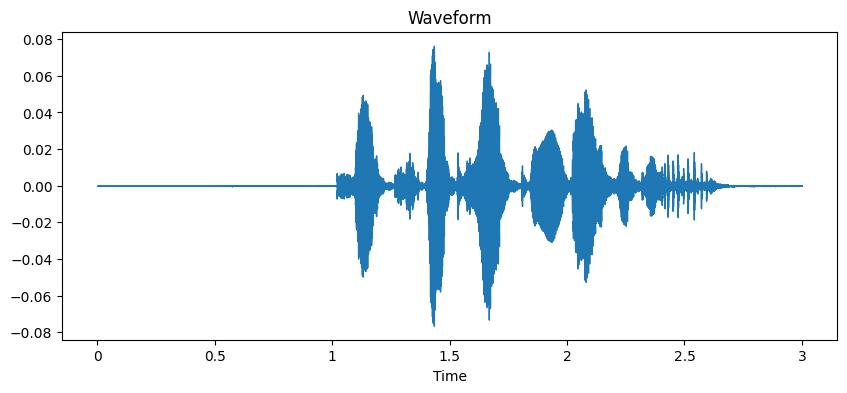

<ipython-input-22-efbc979e0c04>:12: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)


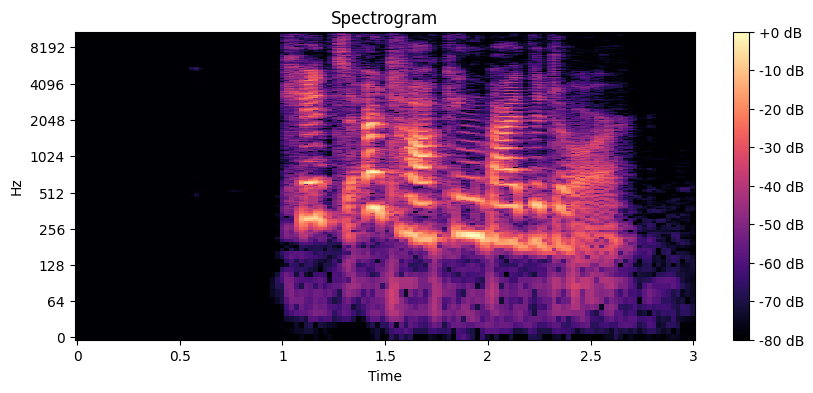

In [ ]:
# Load an example audio file
example_file = os.path.join(main_dir, '/content/drive/MyDrive/Sound_Expression/audio_speech_actors_01-24/Actor_02/03-01-01-01-01-01-02.wav')
y, sr = librosa.load(example_file)

# Display waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.show()

# Display spectrogram
D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()

# **Data Extraction**

In [ ]:
# Function to extract MFCC features from an audio file
def extract_mfcc(file_path, n_mfcc=40):
    X, srr = librosa.load(file_path, sr=None)
    mfccs=np.mean(librosa.feature.mfcc(y=X, sr=srr, n_mfcc=n_mfcc).T, axis=0)
    return mfccs

In [ ]:
sample="/content/drive/MyDrive/Sound_Expression/audio_speech_actors_01-24/Actor_24/03-01-01-01-01-02-24.wav"
mfccs= extract_mfcc(sample, n_mfcc=40)
print(mfccs.shape)

(40,)


In [ ]:
# Function to flatten MFCC, delta, and zero_crossing_rate features
def flatten_features(mfccs):
    mfccs=mfccs.flatten()
    # Concatenate and flatten the features
    #combined_features = np.concatenate((mfccs), axis=0)
    flattened_features = mfccs.flatten()
    return flattened_features

In [ ]:
sample="/content/drive/MyDrive/Sound_Expression/audio_speech_actors_01-24/Actor_24/03-01-01-01-01-02-24.wav"
mfccs= extract_mfcc(sample, n_mfcc=40)
m=flatten_features(mfccs)
print(m.shape)

(40,)


In [ ]:
m

array([-6.8902338e+02,  7.3299118e+01, -1.2480133e+01,  4.7846189e+00,
       -6.1575637e+00,  1.9295423e-01, -1.5466996e+01, -3.8106875e+00,
       -1.3741746e+01, -1.0143926e+01, -5.4531536e+00, -6.4383841e+00,
       -8.0148878e+00, -6.6973071e+00, -2.4665964e+00, -6.1085362e+00,
       -7.7037683e+00, -1.7387971e+00, -5.9882460e+00, -6.0702724e+00,
       -5.0259056e+00, -5.6073284e+00, -4.3520994e+00, -5.4140406e+00,
       -5.3088727e+00, -4.2662802e+00, -5.8025584e+00, -3.0809894e+00,
       -3.6266322e+00, -3.7957158e+00, -1.3440602e+00, -1.4268805e+00,
       -5.5757713e-01,  3.5483286e-02,  4.8379496e-01,  1.8014977e+00,
        1.4498140e+00,  4.3081369e+00,  4.5097909e+00,  5.1903362e+00],
      dtype=float32)

In [ ]:
output_file_path = '/content/drive/MyDrive/Sound_Expression/features_extraction.csv'
m=np.zeros((1439,40))
df2=pd.DataFrame(m)
df2.to_csv(output_file_path, index=False)

In [ ]:
df2.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def extract_features_to_csv(file_paths, labels, output_csv, n_mfcc=13, max_length=40):
    with open(output_csv, 'w') as f:
        # Write header
        header = ['File'] + [f'Feature_{i}' for i in range(max_length)] + ['Label']
        f.write(','.join(header) + '\n')

        for i, file_path in enumerate(file_paths):
            # Extract features
            mfccs= extract_mfcc(file_path, n_mfcc=n_mfcc)
            flattened_features = flatten_features(mfccs)
            label = labels[i]

            # Write row
            row = [f'File_{i}'] + flattened_features.tolist() + [label]
            f.write(','.join(map(str, row)) + '\n')

file_paths = df.iloc[:, 0].values
labels = df.iloc[:, -1].values
output_csv = '/content/drive/MyDrive/Sound_Expression/features_extraction.csv'
extract_features_to_csv(file_paths, labels, output_csv, n_mfcc=40, max_length=40)

In [ ]:
df5=pd.read_csv('/content/drive/MyDrive/Sound_Expression/features_extraction.csv')

In [ ]:
df5.head()

,File,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,...,Feature_31,Feature_32,Feature_33,Feature_34,Feature_35,Feature_36,Feature_37,Feature_38,Feature_39,Label
0,File_0,-700.773926,66.382896,-15.758938,12.378655,-2.779426,2.040216,-16.535204,-0.088404,-11.130050,...,1.251055,4.478389,3.412124,2.810372,3.384351,1.492489,1.330512,-0.347021,0.760702,Neutral
1,File_1,-839.049072,55.327896,-5.580371,17.065023,-2.285674,4.670848,-9.527438,0.471414,-10.288006,...,-3.318586,0.449362,-2.311057,-2.136948,-0.314084,-1.069420,-0.230877,0.111735,2.248993,Calm
2,File_2,-704.830444,59.737816,-10.804083,12.701000,-4.340371,4.029755,-15.786472,0.224077,-13.418603,...,2.118592,2.004011,1.687382,0.033294,1.174982,0.208979,0.434483,0.252360,1.417956,Neutral
3,File_3,-787.132385,59.854774,-5.291254,18.932837,-4.991405,8.691061,-11.437883,0.346918,-10.680456,...,-2.159024,0.738065,-0.943275,1.536372,2.715122,0.830074,1.917877,2.135684,2.334697,Calm
4,File_4,-572.794189,63.435452,-17.273920,4.787412,-2.719661,-1.173192,-17.083836,-2.993031,-10.746663,...,0.897073,2.420309,1.161075,-0.360690,0.655501,0.774936,1.293456,0.429901,1.590757,Happy


In [ ]:
y=df5.iloc[:,-1]

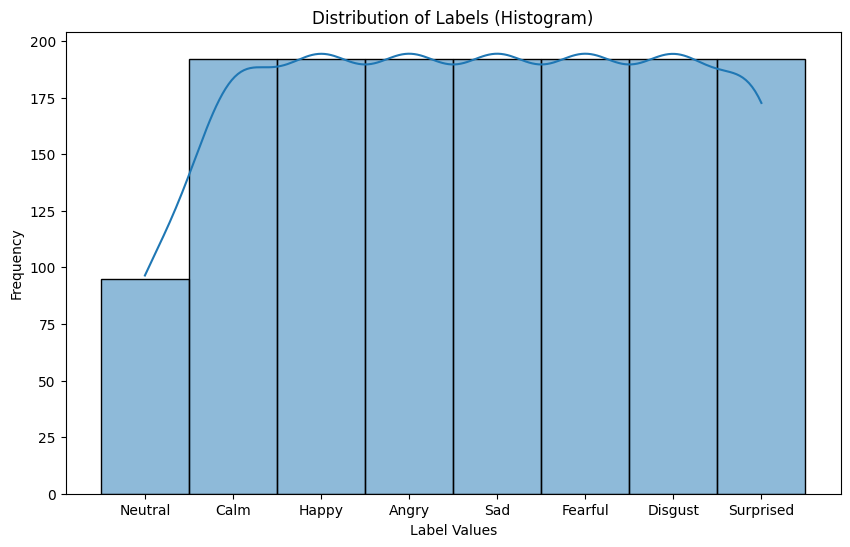

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(y, bins=30, kde=True)
plt.xlabel('Label Values')
plt.ylabel('Frequency')
plt.title('Distribution of Labels (Histogram)')
plt.show()

# **Others Features we can considered when the model are not satisfy**

# Extract chroma features
chroma = librosa.feature.chroma_stft(y=y, sr=sr)

# Extract spectral contrast
spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

# Extract spectral centroid
spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)

# Extract zero-crossing rate
zero_crossing_rate = librosa.feature.zero_crossing_rate(y)

# Extract root mean square energy
rms = librosa.feature.rms(y=y)

# Extract mel spectrogram
mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)


In [ ]:
# Load audio file
# y, sr = librosa.load('your_audio_file.wav', sr=None)

# Extract MFCCs
# mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

# Extract delta and delta-delta coefficients
# mfcc_delta = librosa.feature.delta(mfcc)
# mfcc_delta2 = librosa.feature.delta(mfcc, order=2)

# Extract chroma features
# chroma = librosa.feature.chroma_stft(y=y, sr=sr)

# Extract spectral contrast
# spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

# Extract spectral centroid
# spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)

# Extract zero-crossing rate
# zero_crossing_rate = librosa.feature.zero_crossing_rate(y)

# Extract root mean square energy
# rms = librosa.feature.rms(y=y)

# Extract mel spectrogram
# mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)

# Combine all features
# features = np.concatenate((mfcc, mfcc_delta, mfcc_delta2, chroma, spectral_contrast,
#                            spectral_centroid, zero_crossing_rate, rms, mel_spectrogram), axis=0)

# Shape of features
# print("Shape of combined features: ", features.shape)